# 4: 3D-2D Projections and PnP

When we looked at undistorting an image in the previous [session](03_image_distortion_and_undistortion.ipynb) we saw how we could technically "reproject" a an undistorted image from a distorted image. This is a very important concept in computer vision, and in this session we will look at how we can project a 3D point to a 2D point. We actually forecasted this in the previous session, and I gave a small hint how this is done. Let revisit the same example. Assume you have a 3D coordinate:

$$\left[\begin{array}{cc} X \\ Y \\ Z \end{array}\right]$$

How can we figure out where this point would be seen in the image? We now actually have a straight forward approach:

$$
\left[\begin{array}{cc} X \\ Y \\ Z \end{array}\right] \xrightarrow[Z]{\mathrm{divide}}
\left[\begin{array}{cc} \frac{X}{Z} \\ \frac{Y}{Z} \\ 1\end{array}\right] \xrightarrow[kc]{\mathrm{distort}}
\left[\begin{array}{cc} x' \\ y' \\ 1\end{array}\right] \xrightarrow[K]{\mathrm{denormalize}}
\left[\begin{array}{cc} x \\ y\end{array}\right]
$$

This is the process of projecting a 3D point to a 2D point. The first step is to divide by the depth, which gives us the normalized image coordinates. The second step is to distort the normalized image coordinates. The third step is to denormalize the distorted image coordinates. The resulting image coordinated are where the 3D point would be seen in the image. There are some thing to be aware of:

- There is no guarantee that the point will be visible in the image, as it might be outside the image boundaries.
- If the point is behind the camera, the point will be projected to the image plane, but it will be projected to the opposite side of the image plane. This is why we need to check the depth of the point before projecting it to the image plane. If the depth is negative, the point is behind the camera, since the camera is defined to be positioned at the origin with the optical axis pointing in the $z$-direction.
- If the $z$-coordinate is 0, the division will result in a division by zero. Hence, the projection is not defined at this point. This can be seen as the point being in the plane of the image itself, and at this point the image sensor is "infinitely" small.

## Simple Projection

Let us start by loading a camera calibration and a set of 3D points. For the 3D points I will define a grid in the $xy$-plane, where the $z$-coordinate is 0. This is how we usually define 2D objects like checkerboards etc. in 3D space.

In [55]:
import matplotlib.pyplot as plt
import numpy as np

from oaf_vision_3d.lens_model import CameraMatrix, DistortionCoefficients, LensModel


lens_model = LensModel(
    camera_matrix=CameraMatrix(
        fx=2500.0,
        fy=2500.0,
        cx=1250.0,
        cy=1000.0,
    ),
    distortion_coefficients=DistortionCoefficients(
        k1=0.3,
        k2=-0.1,
        p1=-0.02,
    ),
)

points = np.stack(
    [
        *np.meshgrid(np.linspace(-20, 20, 10), np.linspace(-20, 20, 10)),
        np.zeros((10, 10)),
    ],
    axis=-1,
    dtype=np.float32,
)

I choose to make a grid that is 10x10, and the grid where $x$ and $y$ are in the range $[-20, 20]$, equally spaced with 10 points in each direction. I think of this as being in mm, since this is the unit I usually work in, but this is unitless.

Let's see how this grid look in 3D:

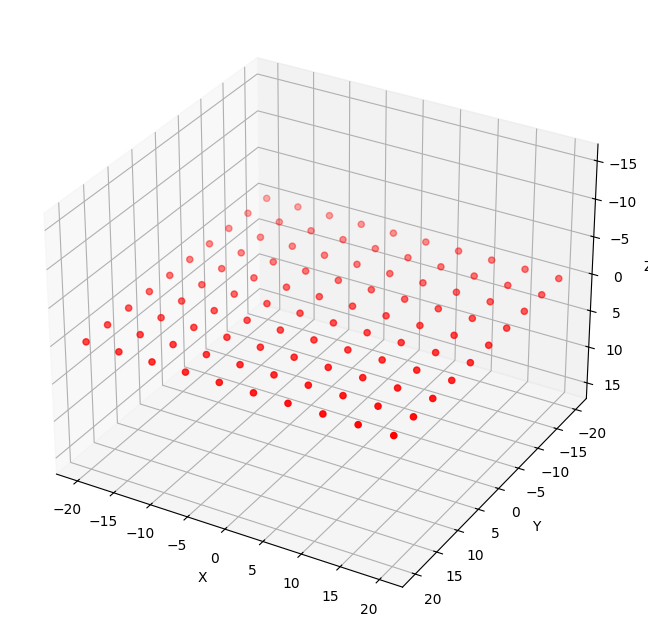

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[..., 0], points[..., 1], points[..., 2], c="r", marker="o")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.axis("equal")
ax.invert_yaxis()
ax.invert_zaxis()
plt.show()

Let's first implement a simple function that follows the above equation to project a 3D point to a 2D point. The steps are:

1. Divide $X$ and $Y$ by $Z$. This is now our normalized undistorted image coordinates, they are undistorted since we are in 3D space.
2. Distort the normalized undistorted image coordinates.
3. Denormalize the distorted image coordinates to get the final image coordinates.

In [57]:
from nptyping import Float32, NDArray, Shape


def project_points_simple(
    points: NDArray[Shape["*, 3"], Float32],
    lens_model: LensModel,
) -> NDArray[Shape["*, 2"], Float32]:
    undistorted_normalized_pixels = points[None, :, :2] / points[None, :, 2:]
    normalized_pixels = lens_model.distort_pixels(
        normalized_pixels=undistorted_normalized_pixels
    )
    return lens_model.denormalize_pixels(pixels=normalized_pixels)[0]

We already know that the projection is undefined if $Z=0$, so for this inital projection I will set the $Z$-coordinate to 100. Let's first see how the grid looks in 3D, we also add the point $(0, 0, 0)$ to show where the camera is located:

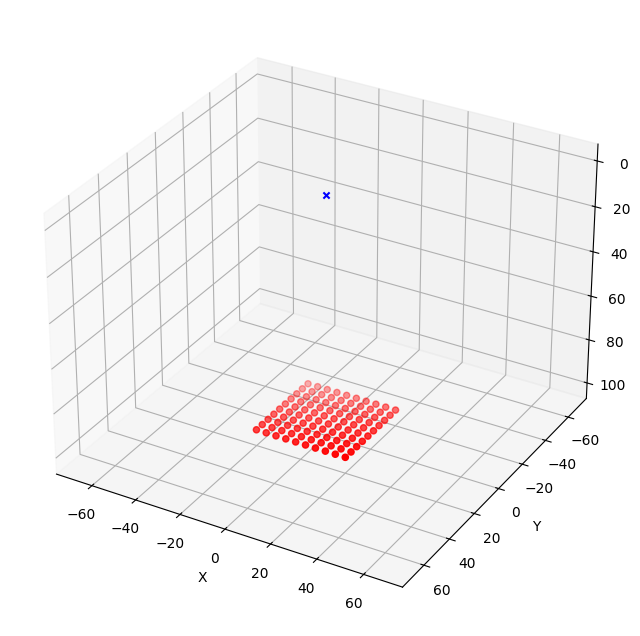

In [58]:
points_shifted = points + np.array([0, 0, 100], dtype=np.float32)[None, None, :]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points_shifted[..., 0],
    points_shifted[..., 1],
    points_shifted[..., 2],
    c="r",
    marker="o",
)
ax.scatter(0, 0, 0, c="b", marker="x")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.axis("equal")
ax.invert_yaxis()
ax.invert_zaxis()
plt.show()

Now we can use our simple projection function to project the 3D points to 2D points:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


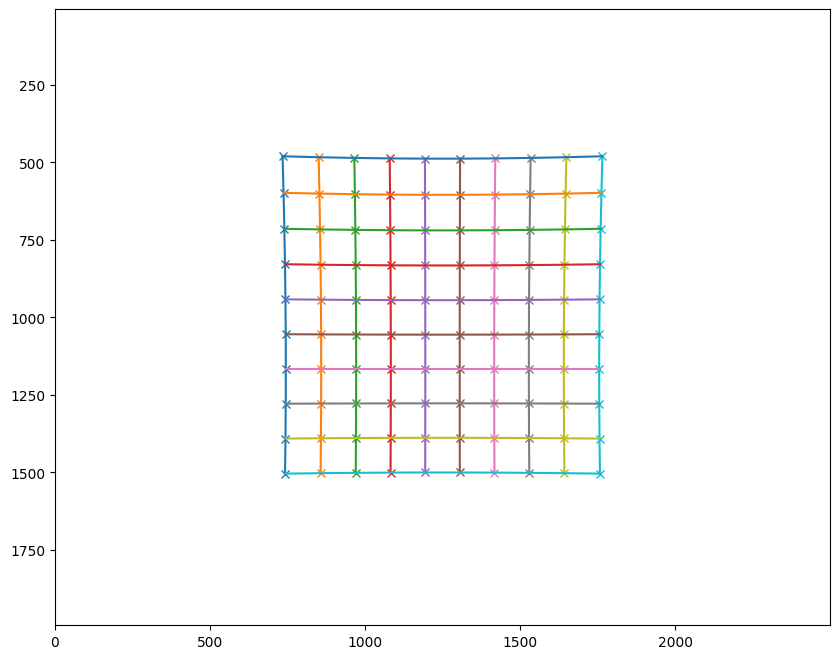

In [59]:
projector_points = project_points_simple(
    points=points_shifted.reshape(-1, 3), lens_model=lens_model
).reshape(10, 10, 2)

plt.figure(figsize=(10, 8))
plt.plot(projector_points[..., 0], projector_points[..., 1], "x-")
plt.plot(projector_points[..., 0].T, projector_points[..., 1].T, "-")
plt.axis("equal")
plt.xlim(0, 2499)
plt.ylim(1999, 0)
plt.show()

## Full Projection

It might be misleading to call it simple and full projection, but in the projection algorithm we usually include a transform of the points. This comes in the form of a rotation and translation, that we apply to the points before projecting. Above I added 100 to all the $Z$-coordinates, which is the same as sending in an translation of $[0, 0, 100]^T$. It is benefitial to use the [Rodrigues rotation vector](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) to represent the rotation, since this is a compact representation of the rotation. The rotation vector give the axis of rotation, and the the lenght of the vector gives the angle of rotation. A big benefit with the rotation vector is that:

1. It is a compact representation of the rotation using only 3 numbers.
2. The rotation vector is differentiable, which is important for optimization algorithms.

We will not implement the Rodrigues rotation vector to rotation matrix, but rather use the OpenCV function `cv2.Rodrigues` to convert the rotation vector to a rotation matrix.

We can now implement the projection function with rotation and translation using the step-by-step approach:

1. Rotate the points using the rotation matrix, which we can directly get from the rotation vector using `cv2.Rodrigues`.
2. Translate the points using the translation vector.
3. Project the points to the image plane using the projection function we implemented above.


In [60]:
import cv2

#simple projection: the real object is in the camera coordinate system(camera(0,0,0))
#full prejection: the real object and camera are in the real world coordinate system, we need to change the coordinate of the real object to that in the camera system--the change will be impacted by the camera coordinates system
def project_points(
    points: NDArray[Shape["*, 3"], Float32],
    rvec: NDArray[Shape["3"], Float32],
    tvec: NDArray[Shape["3"], Float32],
    lens_model: LensModel,
) -> NDArray[Shape["*, 2"], Float32]:
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    transformed_points = points @ rotation_matrix.T + tvec[None, :]

    return project_points_simple(points=transformed_points, lens_model=lens_model)

We can now use an interactive plot to show where the 2D points end up as a function of the 6 parameters in the projection function, $r_x$, $r_y$, $r_z$, $t_x$, $t_y$ and $t_z$:

In [61]:
from ipywidgets import interact, FloatSlider


def plot_with_sliders(
    rx: float, ry: float, rz: float, tx: float, ty: float, tz: float
) -> None:
    rvec = np.array([rx, ry, rz], dtype=np.float32)
    tvec = np.array([tx, ty, tz], dtype=np.float32)

    pixels = project_points(
        points=points.reshape(-1, 3), rvec=rvec, tvec=tvec, lens_model=lens_model
    ).reshape(10, 10, 2)

    plt.figure(figsize=(10, 8))
    plt.plot(pixels[..., 0], pixels[..., 1], "x-")
    plt.plot(pixels[..., 0].T, pixels[..., 1].T, "-")
    plt.axis("equal")
    plt.xlim(0, 2499)
    plt.ylim(1999, 0)
    plt.show()


_ = interact(
    plot_with_sliders,
    rx=FloatSlider(min=-np.pi, max=np.pi, step=0.01, value=0.0),
    ry=FloatSlider(min=-np.pi, max=np.pi, step=0.01, value=0.0),
    rz=FloatSlider(min=-np.pi, max=np.pi, step=0.01, value=0.0),
    tx=FloatSlider(min=-10.0, max=10.0, step=1.0, value=0.0),
    ty=FloatSlider(min=-10.0, max=10.0, step=1.0, value=0.0),
    tz=FloatSlider(min=50, max=200.0, step=1.0, value=100.0),
)

interactive(children=(FloatSlider(value=0.0, description='rx', max=3.141592653589793, min=-3.141592653589793, …

## Perspective-n-Point (PnP) pose computation

A limitation in having 1 2D camera is that, even though we can project a 3D point to a 2D point, we cannot go from a 2D point to a 3D point. This is because any point along the line from the camera center through the 2D point will project to the same 2D point. If we on the other hand have a know 3D object, we can utilize the constraints that the 3D object gives us to estimate the pose of the camera. Estimating the pose of the camera is called Perspective-n-Point (PnP) pose computation and what we try to do is to find the rotation vector and the translation vector that would give the desired projection. In this case we have detected an object in the 2D image and we know how the corresponding 3D coordinates of the object correspond to each other. We will create this using the grid we created above, mainly because it gives us a simple way to create a dataset. And the case above is very similar to capturing a planar calibration object, like a checkerboard. That said, this would work with any know 3D object, a cool example could be that you take an image of New York City and you know the relative positions of the buildings, then you could estimate the where the image was taken from.

The PnP problem is a non-linear optimization problem, and there are several algorithms to solve it. The most common one is the [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) algorithm, which is a combination of the Gauss-Newton algorithm and the steepest descent algorithm. The Levenberg-Marquardt algorithm is implemented in OpenCV with the `cv2.solvePnP` function. Here we will simply use [Gauss-Newton](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) to solve the PnP problem. Let's first create a dataset, that is we will use the above projection and grid with a small adjustment to the rotation vector and translation vector. We will then end up with:

- 3D points: The grid we created above, located in the $xy$-plane with $z=0$.
- 2D points: The corresponding 2D points of the 3D points.

Let's create and plot the dataset:

:::{note}
It is worth mentioning that the PnP problem is a non-linear optimization problem, and it is sensitive to the initial guess. This is why we need to provide a good initial guess to the PnP algorithm. For this course we will limit us self to fairly small rotations and translations from the initial guess. In a real application requires a more robust initialization and possibly a more robust optimization algorithm (like the Levenberg-Marquardt algorithm).
:::

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


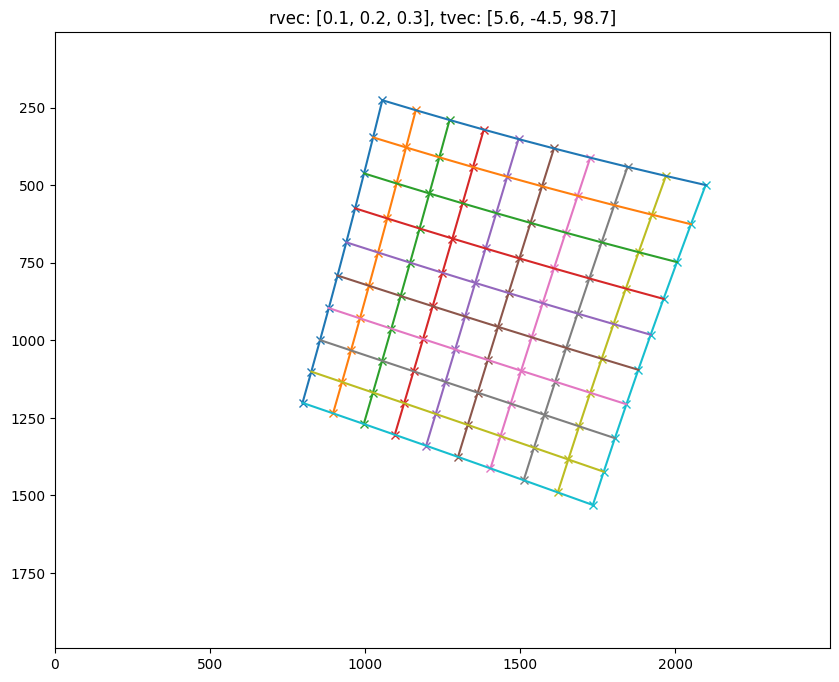

In [62]:
rvec_to_find = np.array([0.1, 0.2, 0.3], dtype=np.float32)
tvec_to_find = np.array([5.6, -4.5, 98.7], dtype=np.float32)

detected_pixels = project_points(
    points=points.reshape(-1, 3),
    rvec=rvec_to_find,
    tvec=tvec_to_find,
    lens_model=lens_model,
).reshape(10, 10, 2)

plt.figure(figsize=(10, 8))
plt.plot(detected_pixels[..., 0], detected_pixels[..., 1], "x-")
plt.plot(detected_pixels[..., 0].T, detected_pixels[..., 1].T, "-")
plt.axis("equal")
plt.xlim(0, 2499)
plt.ylim(1999, 0)
plt.title(
    f"rvec: [{rvec_to_find[0]:.1f}, {rvec_to_find[1]:.1f}, {rvec_to_find[2]:.1f}], tvec: [{tvec_to_find[0]:.1f}, {tvec_to_find[1]:.1f}, {tvec_to_find[2]:.1f}]"
)
plt.show()

### OpenCV

Just to show that this works we can use the OpenCV function `cv2.solvePnP` to solve the PnP problem and see what the resulting $rvec$ and $tvec$ are:

In [63]:
_, opencv_rvec, opencv_tvec = cv2.solvePnP(
    objectPoints=points.reshape(-1, 3),
    imagePoints=detected_pixels.reshape(-1, 2),
    cameraMatrix=lens_model.camera_matrix.as_matrix(),
    distCoeffs=lens_model.distortion_coefficients.as_opencv_vector(),
)
opencv_rvec = opencv_rvec.squeeze()
opencv_tvec = opencv_tvec.squeeze()

print(
    f"rvec: [{rvec_to_find[0]:.1f}, {rvec_to_find[1]:.1f}, {rvec_to_find[2]:.1f}], opencv_rvec: [{opencv_rvec[0]:.3f}, {opencv_rvec[1]:.3f}, {opencv_rvec[2]:.3f}]"
)
print(
    f"tvec: [{tvec_to_find[0]:.1f}, {tvec_to_find[1]:.1f}, {tvec_to_find[2]:.1f}], opencv_tvec: [{opencv_tvec[0]:.3f}, {opencv_tvec[1]:.3f}, {opencv_tvec[2]:.3f}]"
)

rvec: [0.1, 0.2, 0.3], opencv_rvec: [0.100, 0.200, 0.300]
tvec: [5.6, -4.5, 98.7], opencv_tvec: [5.600, -4.500, 98.700]


### Our implementation

It is not a suprise that OpenCV works, but can we implement this ourself? Let's try to implement the Gauss-Newton algorithm to solve the PnP problem. The Gauss-Newton algorithm is an iterative algorithm that tries to minimize the error between the observed 2D points and the projected 3D points. The algorithm is iterative and the update step is given by:

$$
\left[\begin{array}{cc} r_{\text{new}} \\ t_{\text{new}} \end{array}\right] = \left[\begin{array}{cc} r \\ t \end{array}\right] - \left(J^T J\right)^{-1} J^T E
$$

where $r$ and $t$ are the current estimates of the rotation vector and translation vector, $J$ is the Jacobian matrix of the error function and $E$ is the error vector. The error vector is the difference between the observed 2D points and the projected 3D points. The Jacobian matrix is the derivative of the error vector with respect to the rotation vector and translation vector. We could get the Jacobian matrix our self but we will use the `cv2.projectPoints` function for this. The `cv2.projectPoints` function will give us the Jacobian matrix as well as the projected 2D points. 

Here is an implementation we can use to get both the projection and the jacobian matrix:

:::{note}
You might see that I only extract the first 6 values of the jacobian matrix, these values correspond to the rotation vector and translation vector. The rest of the values of the jacobian matrix corresponds to the camera matrix and the distortion coefficients. We will not use these values since we only are solving the PnP problem, but this is actually how you do a full camera calibration for all the parameters in the camera model. Although that require a lot more 2D-3D correspondences to reach the required rank.
:::

In [64]:
def project_points_with_jacobian(
    points: NDArray[Shape["*, 3"], Float32],
    rvec: NDArray[Shape["3"], Float32],
    tvec: NDArray[Shape["3"], Float32],
    lens_model: LensModel,
) -> tuple[NDArray[Shape["*, 2"], Float32], NDArray[Shape["*, 2, 6"], Float32]]:
    projected_points, jacobian = cv2.projectPoints(
        objectPoints=points,
        rvec=rvec,
        tvec=tvec,
        cameraMatrix=lens_model.camera_matrix.as_matrix(),
        distCoeffs=lens_model.distortion_coefficients.as_opencv_vector(),
    )
    return (
        projected_points.astype(np.float32)[:, 0, :],
        jacobian.astype(np.float32)[:, :6].reshape(-1, 2, 6),
    )

Now we should have everything we need to implement the Gauss-Newton algorithm to solve the PnP problem. The step-by-step approach could look somehing like:

1. Initialize the rotation vector and translation vector to some initial guess, its important that we don't start with a values that make the $Z$-coordinates 0. We can for example start with $r = [0, 0, 0]^T$ and $t = [0, 0, 100]^T$.
2. Project the 3D points to the 2D points using the current estimates of the rotation vector and translation vector, getting both the projected 2D points and the Jacobian matrix.
3. Compute the error vector as the difference between the observed 2D points and the projected 2D points. $E = P_{\text{obs}} - P_{\text{proj}}$.
4. Reshape the error vector to a column vector, from shape (N, 2) to shape (2N,).
5. Rehsape the Jacobian matrix to a matrix with shape (2N, 6).
6. Compute the update step using the Gauss-Newton algorithm: $\Delta = [\Delta r_x, \Delta r_y, \Delta r_z, \Delta t_x, \Delta t_y, \Delta t_z]^T = (J^T J)^{-1} J^T E$. Hint: Use `np.linalg.lstsq` to solve the linear system.
7. Apply the update step to the current estimates of the rotation vector and translation vector: $r_{\text{new}} = r - \Delta r$ and $t_{\text{new}} = t - \Delta t$.
8. Repeat steps 2-7 until the error is below a certain threshold or a maximum number of iterations is reached. The update error can be defined as the norm of the update step: $\text{error} = \|\Delta\|$.



In [71]:
def solve_pnp(
    points: NDArray[Shape["*, 3"], Float32],
    pixels: NDArray[Shape["*, 2"], Float32],
    lens_model: LensModel,
    rvec: NDArray[Shape["3"], Float32] = np.zeros(3, dtype=np.float32),
    tvec: NDArray[Shape["3"], Float32] = np.zeros(3, dtype=np.float32),
    epsilon: float = 1e-5,
    max_iterations: int = 100,
) -> tuple[NDArray[Shape["3"], Float32], NDArray[Shape["3"], Float32]]:
    for i in range(max_iterations):
        projected_2D_points, jacobian=project_points_with_jacobian(points=points,rvec=rvec, tvec=tvec,lens_model=lens_model)
        error=pixels-projected_2D_points
        N=pixels.shape[0]
        error=error.reshape((N*2,))
        jacobian=jacobian.reshape((N*2, 6))
        delta, *_ = np.linalg.lstsq(jacobian, error)
        if(np.linalg.norm(delta)<epsilon):
            break
        rvec=rvec-delta[:3]
        tvec=tvec-delta[3:]
        
    return rvec, tvec

In [72]:
rvec_initial = np.array([0.0, 0.0, 0.0], dtype=np.float32)
tvec_initial = np.array([0.0, 0.0, 100.0], dtype=np.float32)

rvec_tvec = solve_pnp(
    points=points.reshape(-1, 3),
    pixels=detected_pixels.reshape(-1, 2),
    lens_model=lens_model,
    rvec=rvec_initial,
    tvec=tvec_initial,
)
rvec_found, tvec_found = (
    (
        rvec_initial * np.nan,
        tvec_initial * np.nan,
    )
    if rvec_tvec is None
    else (rvec_tvec[0], rvec_tvec[1])
)

print(
    f"rvec: [{rvec_to_find[0]:.1f}, {rvec_to_find[1]:.1f}, {rvec_to_find[2]:.1f}], rvec_found: [{rvec_found[0]:.3f}, {rvec_found[1]:.3f}, {rvec_found[2]:.3f}]"
)
print(
    f"tvec: [{tvec_to_find[0]:.1f}, {tvec_to_find[1]:.1f}, {tvec_to_find[2]:.1f}], tvec_found: [{tvec_found[0]:.3f}, {tvec_found[1]:.3f}, {tvec_found[2]:.3f}]"
)

all_close = np.allclose(rvec_found, rvec_to_find, atol=1e-3) and np.allclose(
    tvec_found, tvec_to_find, atol=1e-3
)
print(f"The solution is {'correct' if all_close else 'incorrect'}!")

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/var/folders/5q/l3jfw2r13t19d7jxf_hj6pkw0000gn/T/ipykernel_93803/3912084003.py:31: RuntimeWarning: overflow encountered in cast
  jacobian.astype(np.float32)[:, :6].reshape(-1, 2, 6),


LinAlgError: SVD did not converge in Linear Least Squares